# Variational Autoencoder

###  <div align=center> Moon Il-chul(icmoon@kaist.ac.kr); Shin Dong-hyeok(tlsehdgur0@kaist.ac.kr) </div> 

본 코드는 MNIST 데이터셋을 이용한 Variational Autoendocer의 구현 예시입니다.  
본 코드를 통해서 Variational Autoencoder의 구조와 생성, 학습 과정을 익힐 수 있습니다.  
또한 본 코드를 통하여 latent space를 plot 해봄으로써 latent varible의 정보를 살펴볼 수 있습니다. 


## Variational Inference 

Probability model에 variational inference를 적용하면 latent variable의 distribution에 대한 정보를 얻을 수 있습니다. 다시 말해, Variational Inference를 이용하면 우리는 probability model의 Evidence(E)로부터 숨겨진 Hypothesis(H)를 estimate 할 수 있습니다.  
우리의 목적은 관측값 E로부터 숨겨진 H의 distribution에 대한 정보를 구하는 것이므로, 이는 $P(H \mid E)= \frac{P(H,E)}{P(E)}$를 구하는 것과 같습니다. 이때, P(E)는 모든 H에 대한 marginalization을 통하여 얻을 수 있는데, 이는 어려운 과정이므로 P(E)를 variational approximate하는 방법으로 접근합니다.  

먼저 ln x의 monotonically increase하는 성질을 이용하여 likelihood P(E)를 직접 사용하는 것보다 log-likelihood lnP(E)를 사용하면 동일한 결과를 더욱 편리하게 도출할 수 있습니다. log-likelihood lnP(E)를 H에 대하여 marginalize하면 아래와 같습니다.  
$$lnP(E)=ln \sum_{H} P(H,E)$$
우리는 더 이상 수식을 전개할 수 없으므로 정보를 충분히 가지고 있는 Auxiliary function $Q(H \mid E)$를 도입하여 수식을 아래와 같이 전개할 수 있습니다.
$$lnP(E)=ln \sum_{H} P(H,E)=ln \sum_{H} Q(H \mid E) \frac{P(H,E)}{Q(H \mid E)}$$
더 나아가 ln x 함수에 대한 젠센 부등식과 conditional probability의 정의를 활용하면 아래와 같이 lnP(E)에 대한 lower bound를 구할 수 있습니다.  
$$ln \sum_{H} Q(H \mid E) \frac{P(H,E)}{Q(H \mid E)}\ge \sum_{H} Q(H \mid E) ln[\frac{P(H,E)}{Q(H \mid E)}]=\sum_{H} Q(H \mid E)lnP(H,E)-Q(H \mid E)lnQ(H\mid E)= \sum_{H} Q(H \mid E)(lnP(E \mid H)+lnP(H))-Q(H \mid E)lnQ(H\mid E)=\sum_{H} Q(H \mid E) lnP(E \mid H) - Q(H \mid E) \frac{lnQ(H \mid E)}{lnP(H)}=E_{Q(H \mid E)}[lnP(E \mid H)] - KL(Q(H \mid E) \parallel P(H))$$
이때, 구해진 lnP(E)의 lower bound를 ELBO(evidence lower bound)라고 부릅니다.  
궁극적으로 구하고자 했던 실제 lnP(E)를 구하기 위해서는 lower bound를 증가시켜야 하므로 KL Divergence 항을 minimize 하는 방향으로 진행하면 됩니다. 

## Variational Autoencoder 

VAE는 Variational Inference와 Autoencoder가 결합된 generative model입니다.  
위에서 언급한 것과 같이 고차원의 데이터(X)에 대한 저차원 변수(z)의 표현법을 구할 수 있다면, z의 변화에 따른 데이터의 변화를 관찰할 수 있으며 새로운 데이터를 생성할 수도 있습니다. 그러나 z는 관측되지 않은 변수이므로 variational approximation $q(z \mid x)$를 이용하여 posterior probability $p(z \mid x)$를 근사해야하고 ELBO를 maximize하는 방향으로 진행해야 합니다.  

Posetrior probability $p(z \mid x)$는 $\frac{p(z)p(x \mid z)}{p(x)}$로 표현할 수 있습니다. 이때, $p(x)$는 variational inference로, $p(z)$는 가정을 통한 prior probability로 구할 수 있습니다. $p(x \mid z)$는 주어진 z에 대한 x의 확률을 나타낸 것이므로 decoder model에 해당합니다. 마찬가지의 방식으로 $q(z \mid x)$ 주어진 x에 대한 z의 확률을 나타내므로 encoder model에 해당합니다. 이 두 model을 결합하면 x에서 x를 생성하는 Autoencoder 형태를 가지게 됩니다.  

결론적으로 VAE는 variational inference를 이용하여 latent variable의 분포를 관찰할 수 있음과 동시에 Autoencoder의 형태를 이용하여 Input X를 reconstruct할 수 있는 모델입니다. 

In [1]:
'''
@ copyright: AAI lab (http://aailab.kaist.ac.kr/xe2/page_GBex27)
@ author: Moon Il-chul: icmoon@kaist.ac.kr
@ annotated by Shin Dong-hyeok: tlsehdgur0@kaist.ac.kr
'''

import time
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
class VariationalAutoEncoder:

    network_architecture = [] # network_architecture : 인공신경망의 구조를 저장
    transfer_fct = 0

    x = [] # x : VAE의 Input
    x_reconstr_mean = [] # x_reconstr_mean : VAE의 Output
    z = [] # z : VAE의 latent variable
    z_mean = [] # z_mean : VAE의 latent variable의 mean
    z_log_sigma_sq = [] # z_log_sigma_sq : VAE의 latent variable의 log sigma sq

    sess = 0
    cost = 0
    optimizer = 0

    def __init__(self,network_architecture,transfer_fct=tf.nn.sigmoid):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct # self.transfer_fct : activation function을 저장, 기본값은 sigmoid function으롤 설정

        self.x = tf.placeholder(tf.float32,[None,network_architecture["n_input"]])

    def _create_network(self,batch_size): 
        # VAE를 생성하는 method
        # initialize weight -> recognition network -> Reparameterization trick -> generator network
        
        network_weights = self._initialize_weights(**self.network_architecture)

        self.z_mean, self.z_log_sigma_sq = self._recognition_network(network_weights["weights_recog"],network_weights["biases_recog"])

        n_z = self.network_architecture["n_z"]
        
        # Reparameteriation trick
        eps = tf.random_normal((batch_size,n_z),0,1,dtype=tf.float32)

        self.z = tf.add(self.z_mean,tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)),eps))

        self.x_reconstr_mean = self._generator_network(network_weights["weights_gener"],network_weights["biases_gener"])

    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, n_hidden_gener_1, n_hidden_gener_2, n_input, n_z):
        # VAE의 전체 weights의 초기값을 설정하여 dictionary로 return하는 method
        # Input : n_hidden_recog_1, n_hidden_recog_2, n_hidden_gener_1, n_hidden_gener_2, n_input, n_z
        # Output : all_weights
        
        all_weights = dict()
        
        # Recognition Network의 weight의 초기값 설정 with Xavier initialization
        all_weights['weights_recog'] = { 'h1' : tf.Variable(self.xavier_init(n_input,n_hidden_recog_1)), \
                                         'h2' : tf.Variable(self.xavier_init(n_hidden_recog_1,n_hidden_recog_2)), \
                                         'out_mean': tf.Variable(self.xavier_init(n_hidden_recog_2, n_z)), \
                                         'out_log_sigma': tf.Variable(self.xavier_init(n_hidden_recog_2, n_z))}

        # Recognition Network의 bias의 초기값 설정 with 0
        all_weights['biases_recog'] = { 'b1' : tf.Variable(tf.zeros([n_hidden_recog_1],dtype=tf.float32)), \
                                        'b2' : tf.Variable(tf.zeros([n_hidden_recog_2],dtype=tf.float32)), \
                                        'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)), \
                                        'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        
        # Generator Network의 weight의 초기값 설정 with Xavier initialization
        all_weights['weights_gener'] = {'h1': tf.Variable(self.xavier_init(n_z, n_hidden_gener_1)), \
                                        'h2': tf.Variable(self.xavier_init(n_hidden_gener_1, n_hidden_gener_2)), \
                                        'out_mean': tf.Variable(self.xavier_init(n_hidden_gener_2, n_input)), \
                                        'out_log_sigma': tf.Variable(self.xavier_init(n_hidden_gener_2, n_input))}
        
        # Generator Network의 bias의 초기값 설정 with 0
        all_weights['biases_gener'] = {'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)), \
                                       'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)), \
                                       'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)), \
                                       'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights

    def _recognition_network(self,weights,biases):
        # VAE의 recognition network의 역할을 수행하는 method
        # Input : (recognition network의) weights, biases
        # Output: (z_mean, z_log_sigma_sq)
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), biases['b1'])) # L1 = g(b1 + W1*X)
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])) # L2 = g(b2 + W2*L1)
        z_mean = tf.add(tf.matmul(layer_2,weights['out_mean']),biases['out_mean']) # z_mean = b_{out_mean} + W_{out mean}*L2
        z_log_sigma_sq = tf.add(tf.matmul(layer_2,weights['out_log_sigma']),biases['out_log_sigma'])
        # z_log_sigma_sq = b_{log_sigma_sq} + W_{log_sigma_sq}*L2
        return (z_mean,z_log_sigma_sq)

    def _generator_network(self,weights,biases):
        # VAE의 generator network의 역할을 수행하는 method
        # Input : (generator network의) weights, biases
        # Output : x_reconstr_mean
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), biases['b1'])) # L1 = g(b1 + W1*Z)
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])) # L2 = g(b2 + W2*L1)
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean']))
        # x_reconstr_mean = b_{out_mean}+W_{out_mean}*L2

        return x_reconstr_mean

    def _create_loss_optimizer(self,learning_rate):
        # VAE의 total cost를 계산하고, 이를 minimize하는 optimizer 설정하는 메소드
        # Input : learning_rate
        # Output : None
        
        # reconstruction loss function = binary cross-entropy function
        reconstr_loss = -tf.reduce_sum(self.x*tf.log(1e-10+self.x_reconstr_mean)+(1-self.x)*tf.log(1e-10+1-self.x_reconstr_mean),1)
        
        # latent loss function = KL-divergence
        latent_loss = -0.5*tf.reduce_sum(1+self.z_log_sigma_sq-tf.square(self.z_mean)-tf.exp(self.z_log_sigma_sq),1)
        
        # (VAE의 total) cost = reconstruction loss + latent loss 
        self.cost = tf.reduce_mean(reconstr_loss+latent_loss)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)

    def partial_fit(self,x):
        # VAE를 통하여 학습한 Input data x의 cost를 출력하는 메소드 
        # Input : x
        # Output : cost
        opt,cost = self.sess.run((self.optimizer,self.cost),feed_dict={self.x:x})
        return cost

    def transform(self,x):
        # VAE의 encoder network를 통하여 latent variable z의 mean을 return하는 메소드
        # Input : x
        # Output : z_mean
        return self.sess.run(self.z_mean,feed_dict={self.x:x})

    def generate(self,z_mu=None):
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        return self.sess.run(self.x_reconstr_mean,feed_dict={self.z:z_mu})

    def reconstruct(self,x):
        # VAE를 통하여 X를 reconstruct한 후, 이의 mean을 return하는 메소드
        # Input : x
        # Output : (VAE를 통한) x_reconstr_mean
        return self.sess.run(self.x_reconstr_mean,feed_dict={self.x:x})

    def xavier_init(self,fan_in, fan_out, constant=1): 
        # Xavier initialization method
        # Input : fan_in(들어오는 layer의 크기), fan_out(나가는 layer의 크기)
        # Output : 각 원소가 random uniform value인 (fan_in, fan_out) 형태의 tensor 
        low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
        high = constant * np.sqrt(6.0 / (fan_in + fan_out))

        return tf.random_uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.float32)

    def train(self,trainX,batch_size=100,training_epochs=500,learning_rate=0.0005):
        # VAE를 생성하고, trainX를 training하는 메소드
        # Input : trainX, batch_size, training_epochs, learning_rate
        # Output : None
        
        total_costs = np.zeros(training_epochs)
        
        self._create_network(batch_size) # VAE 생성
        self._create_loss_optimizer(learning_rate) # VAE의 loss function과 optimizer 생성

        init = tf.initialize_all_variables()
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
        self.sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
        # session : tensorflow를 올려놓아 실행을 진행하기 위한 공간
        self.sess.run(init)

        startTime = time.time()
        for epoch in range(training_epochs): # training_epochs만큼 반복 실행
            avg_cost = 0. # training set의 average cost 
            total_batch = int(len(trainX)/batch_size) # total batch : 전체 batch의 갯수

            for i in range(total_batch): # total_batch만큼 반복 실행
                batch = [] 
                for j in range(batch_size):
                    batch.append(trainX[i*batch_size+j]) # training X를 여러개로 batch로 나누는 과정
                    
                cost = self.partial_fit(batch) # i번째 batch의 cost 계산
                avg_cost += cost / n_samples*batch_size
            
            total_costs[epoch] = avg_cost
            
            print("Epoch : ",'%04d'%(epoch+1)," Cost = ","{:.9f}".format(avg_cost))
            print("Elapsed Time : " + str((time.time() - startTime))) # 각 epcoh의 실행 소요 시간 
        
        # epcch에 따른 cost 그래프 출력 과정
        plt.plot(total_costs)
        plt.xlabel('epoch')
        plt.ylabel('cost')
        plt.show()
        return

    def plotReconstruct(self,testData,strFileName):
        # testData를 VAE를 통해 reconstruct한 후, Input test image와 reconstructedf output image를 plot하는 메소드  
        idxLastSlash = strFileName.rfind("/")
        if os.path.exists(strFileName[0:idxLastSlash]) == False:
            os.makedirs(strFileName[0:idxLastSlash])

        x_reconstruct = self.reconstruct(testData) # x_reconstruct : testData를 이용하여 X를 reconstruct한 데이터
        plt.figure(figsize=(8, 12))
        for i in range(5): # testData의 처음 5개를 plot
            
            # Original Input image plot
            plt.subplot(5, 2, 2 * i + 1)
            plt.imshow(testData[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray") # 784 차원의 벡터를 28*28 픽셀의 이미지로 변환
            plt.title("Test Input")
            plt.colorbar()
            
            # Reconstructed Output image plot
            plt.subplot(5, 2, 2 * i + 2)
            plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray") # 784 차원의 벡터를 28*28 픽셀의 이미지로 변환
            plt.title("Reconstruction")
            plt.title("Reconstruction")
            plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName, bbox_inches='tight')
        plt.close()

    def plotScatter2D(self,testDataFeature,testDataClass,strFileName):
        # test data와 label을 2-D latent Space위에 Scatter plot으로 표현하는 메소드
        
        idxLastSlash = strFileName.rfind("/")
        if os.path.exists(strFileName[0:idxLastSlash]) == False:
            os.makedirs(strFileName[0:idxLastSlash])

        z_mu = self.transform(testDataFeature)
        plt.figure(figsize=(8, 6))
        plt.scatter(z_mu[:,0],z_mu[:,1],c=np.argmax(testDataClass,1))
        plt.colorbar()
        plt.grid()

        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName, bbox_inches='tight')
        plt.close()

    def plotManifold2D(self,intNumX1,intNumX2,maxX1,minX1,maxX2,minX2,batch_size,strFileName):
        # walking in latent space를 표현하는 메소드
        x1s = np.linspace(minX1, maxX1, intNumX1)
        x2s = np.linspace(minX2, maxX2, intNumX2)
        canvas = np.empty((28*intNumX2,28*intNumX1))
        for i, yi in enumerate(x1s):
            for j, xi in enumerate(x2s):
                z_mu = np.array([[xi,yi]]*batch_size)
                x_mean = self.generate(z_mu)
                canvas[(intNumX1-i-1)*28:(intNumX1-i)*28,j*28:(j+1)*28] = x_mean[0].reshape(28,28)
        plt.figure(figsize=(8, 6))
        xi, yi = np.meshgrid(x1s,x2s)
        plt.imshow(canvas,origin='upper',cmap='gray')
        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName, bbox_inches='tight')
        plt.close()

In [3]:
np.random.seed(0)
tf.set_random_seed(0)

mnist = input_data.read_data_sets('MNIST_DATA',one_hot=True) # MNIST 데이터를 one-hot representation vector 형태로 다운로드한다.
n_samples = mnist.train.num_examples

iterations = [1,5]
testX = mnist.test.next_batch(100)[0] # testX : MNIST의 test 데이터셋 중에서 input(=image)을 100(=batch의 크기)만큼 batch로 저장
trainX = []
for i in range(n_samples): 
    tempTuple = mnist.train.next_batch(1)[0]
    trainX.append(tempTuple[0])

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_DATA\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_DATA\train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_DATA\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_DATA\t10k-labels-idx1-ubyte.gz


## VAE with 10 dimension of latent space

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch :  0001  Cost =  205.122384949
Elapsed Time : 15.400485277175903
Epoch :  0002  Cost =  184.449489996
Elapsed Time : 30.93888568878174
Epoch :  0003  Cost =  166.751827004
Elapsed Time : 46.491273164749146
Epoch :  0004  Cost =  155.834146368
Elapsed Time : 62.30849838256836
Epoch :  0005  Cost =  146.281243092
Elapsed Time : 77.90985798835754
Epoch :  0006  Cost =  142.415533309
Elapsed Time : 93.9029746055603
Epoch :  0007  Cost =  139.863212322
Elapsed Time : 109.54230976104736
Epoch :  0008  Cost =  138.042560952
Elapsed Time : 125.20463156700134
Epoch :  0009  Cost =  136.604169894
Elapsed Time : 140.7120487689972
Epoch :  0010  Cost =  135.462723375
Elapsed Time : 156.27243947982788
Epoch :  0011  Cost =  134.454685156
Elapsed Time : 171.8178277015686
Epoch :  0012  Cost =  133.572400305
Elapsed Time : 187.4451699256897
Epoch :  0013  Cost =  132.659808780
Elapsed Time : 202.98956608772278
Epoch :  00

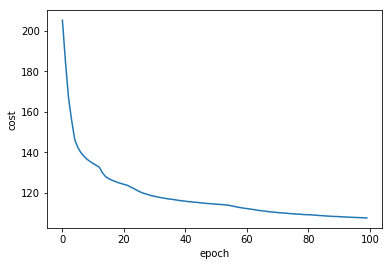

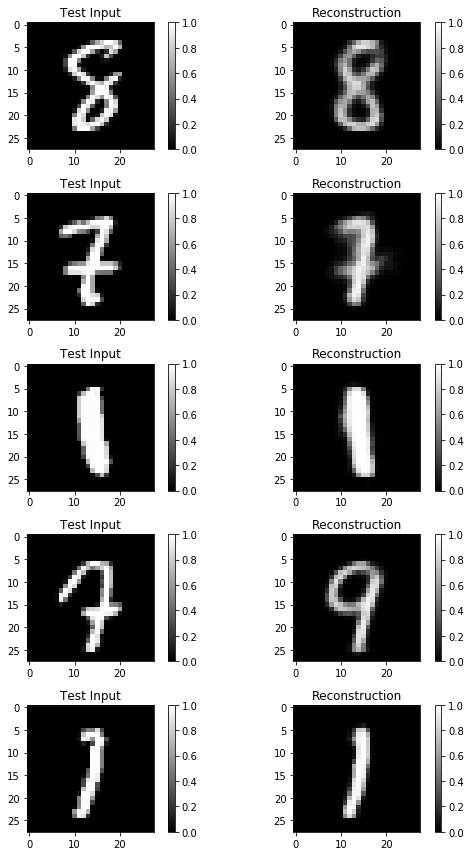

In [4]:
# z dimension이 10인 VAE의 구조를 저장
# 784 500 500 10 500 500 784
network_architecture = dict(n_hidden_recog_1=500,\
                            n_hidden_recog_2=500,\
                            n_hidden_gener_1=500,\
                            n_hidden_gener_2=500,\
                            n_input=784,\
                            n_z=10)

vae = VariationalAutoEncoder(network_architecture) # z dimension이 10인 VAE instance 생성  
vae.train(trainX,batch_size=100,training_epochs=100,learning_rate=0.001) # VAE training
vae.plotReconstruct(testX,'./log/VAE-Reconstruct.png') # testX를 이용하여 reconstruct한 후 이를 plot

## 결과해석부1

위의 출력 결과는 latent space가 10차원인 VAE로 학습한 결과입니다.

출력문은 각 epoch의 average cost와 실행 소요 시간을 나타낸 것이며, 그래프는 x축은 epoch, y축은 cost로 그래프를 표현한 것입니다.  
또한 출력된 10개의 image 중 좌측의 5개는 Original Input test image이고, 우측의 5개는 좌측의 데이터로 reconstruct한 Output image입니다.  

위의 출력 결과를 통해 Training을 진행할수록(Epoch가 증가할수록), total cost가 꾸준히 감소함을 확인할 수 있습니다.  
또한 Original input data image와 Reconstructed output data가 유사함을 관찰할 수 있습니다.

이는 구현한 VAE가 유의미하게 learning되었음을 알 수 있습니다. 

## VAE with 2 dimension of latent space

Epoch :  0001  Cost =  235.006166215
Elapsed Time : 15.00672698020935
Epoch :  0002  Cost =  206.401071444
Elapsed Time : 29.54674243927002
Epoch :  0003  Cost =  206.301598289
Elapsed Time : 44.86427593231201
Epoch :  0004  Cost =  206.282136397
Elapsed Time : 60.16582179069519
Epoch :  0005  Cost =  206.271527100
Elapsed Time : 75.5782961845398
Epoch :  0006  Cost =  206.265225220
Elapsed Time : 89.21586918830872
Epoch :  0007  Cost =  206.258533825
Elapsed Time : 102.77049422264099
Epoch :  0008  Cost =  206.186318970
Elapsed Time : 116.24716448783875
Epoch :  0009  Cost =  198.464776334
Elapsed Time : 129.65088272094727
Epoch :  0010  Cost =  191.778328913
Elapsed Time : 142.7367968559265
Epoch :  0011  Cost =  189.454644775
Elapsed Time : 155.8886682987213
Epoch :  0012  Cost =  187.900823697
Elapsed Time : 170.1428611278534
Epoch :  0013  Cost =  186.634624689
Elapsed Time : 186.94547748565674
Epoch :  0014  Cost =  185.364088024
Elapsed Time : 200.03638863563538
Epoch :  0015  C

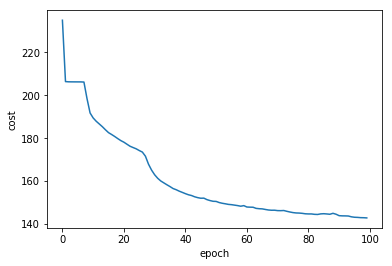

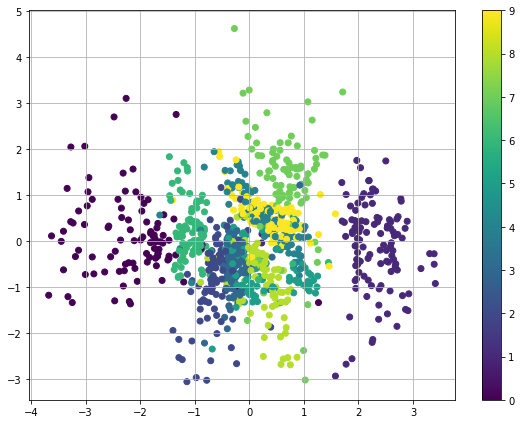

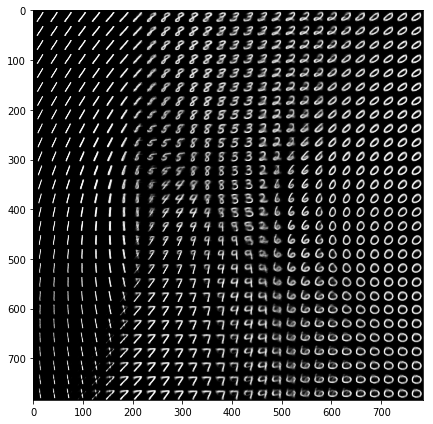

In [5]:
# z dimentsion이 2인 VAE의 구조를 저장
# 784 500 500 2 500 500 784
network_architecture2D = dict(n_hidden_recog_1=500,\
                            n_hidden_recog_2=500,\
                            n_hidden_gener_1=500,\
                            n_hidden_gener_2=500,\
                            n_input=784,\
                            n_z=2)

testX,testY = mnist.test.next_batch(1000)

vae2D = VariationalAutoEncoder(network_architecture2D)
vae2D.train(trainX,batch_size=1000,training_epochs=100,learning_rate=0.001)
vae2D.plotScatter2D(testX,testY,'./log/VAE-2D-Scatter.png')
vae2D.plotManifold2D(28,28,-3,3,-3,3,1000,'./log/VAE-2D-Manifold.png')

## 결과 해석부2

위의 출력 결과는 latent space가 2차원인 VAE로 학습한 결과입니다.

출력문은 각 epoch의 average cost와 실행 소요 시간을 나타낸 것이며, 그래프는 x축은 epoch, y축은 cost로 그래프를 표현한 것입니다.  
그 다음 그래프는 색깔로 label(= digit)을 표현한 test data가 2차원 latent space의 scatter plot이고,  
마지막 그래프는 walking in latent space으로 latent variable z값을 조금씩 바꾸면 reconstructed output image가 어떻게 변화하는지를 표현한 것입니다.  

latent space가 10차원인 경우와 유사하게 Training을 진행할수록 cost가 감소하는 것을 확인할 수 있습니다.  

Scatter plot에서는 진한 보라색(=0)과 보라색(=1)이 양 끝에 clear하게 위치함을 관찰할 수 있습니다.  
그러나 중앙 부분은 여러 색들이 혼합되어 정확하게 분리하기엔 어려움이 있으며 추가적인 정보가 필요하다고 할 수 있습니다.

Walking in latent space 그래프 또한 scatter plot과 유사하게 양 끝에는 0과 1이 나타나며 중앙 부분은 숫자가 흐리게 reconstruct 되었음을 확인할 수 있습니다.